# In this notebook, whole reconstruction pipeline without butter_filter  is illustrated
tdms(raw_data) --> ICA --> HOSD (higher-order spectral filtering)

without butter filtering, ICA almost takes twice as much time that of with butter filter
and it has no effect on higher order filtering.

In [2]:
import sys
sys.path.append('../')

In [2]:
import functions
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from hosd_python.hosd import apply_hosd # library that I converted from MATLAB
from copy import deepcopy

In [3]:
no_ica_chans = 18
fs=1000
span = 10*fs
offset = 100*fs 
ms2s = lambda x, _:f'{x/1000:g}' 

### Here we read the data from tdms file, which returns a np.array of n_samples x n_channels, since we have 16 sensors with 2 directions each, we have 32 channel in total, then we take the deepcopy of the data so not to destroy it

In [4]:

data = functions.array_from_TDMSgroup("patients/P044/P044_S01_D2024-04-18_G36.tdms", "R001")
copied_data = deepcopy(data)

### Without Butter filter, we apply FASTICA, and observe if fetal component is clearly obtainable, but it seems from the figures below, without applying basic Low-pass, notch filter for 50 Hz power lines interference, we couldn't see the fetal component

In [7]:
components = functions.FASTICA(copied_data[5000:, 1:], no_ica_chans)

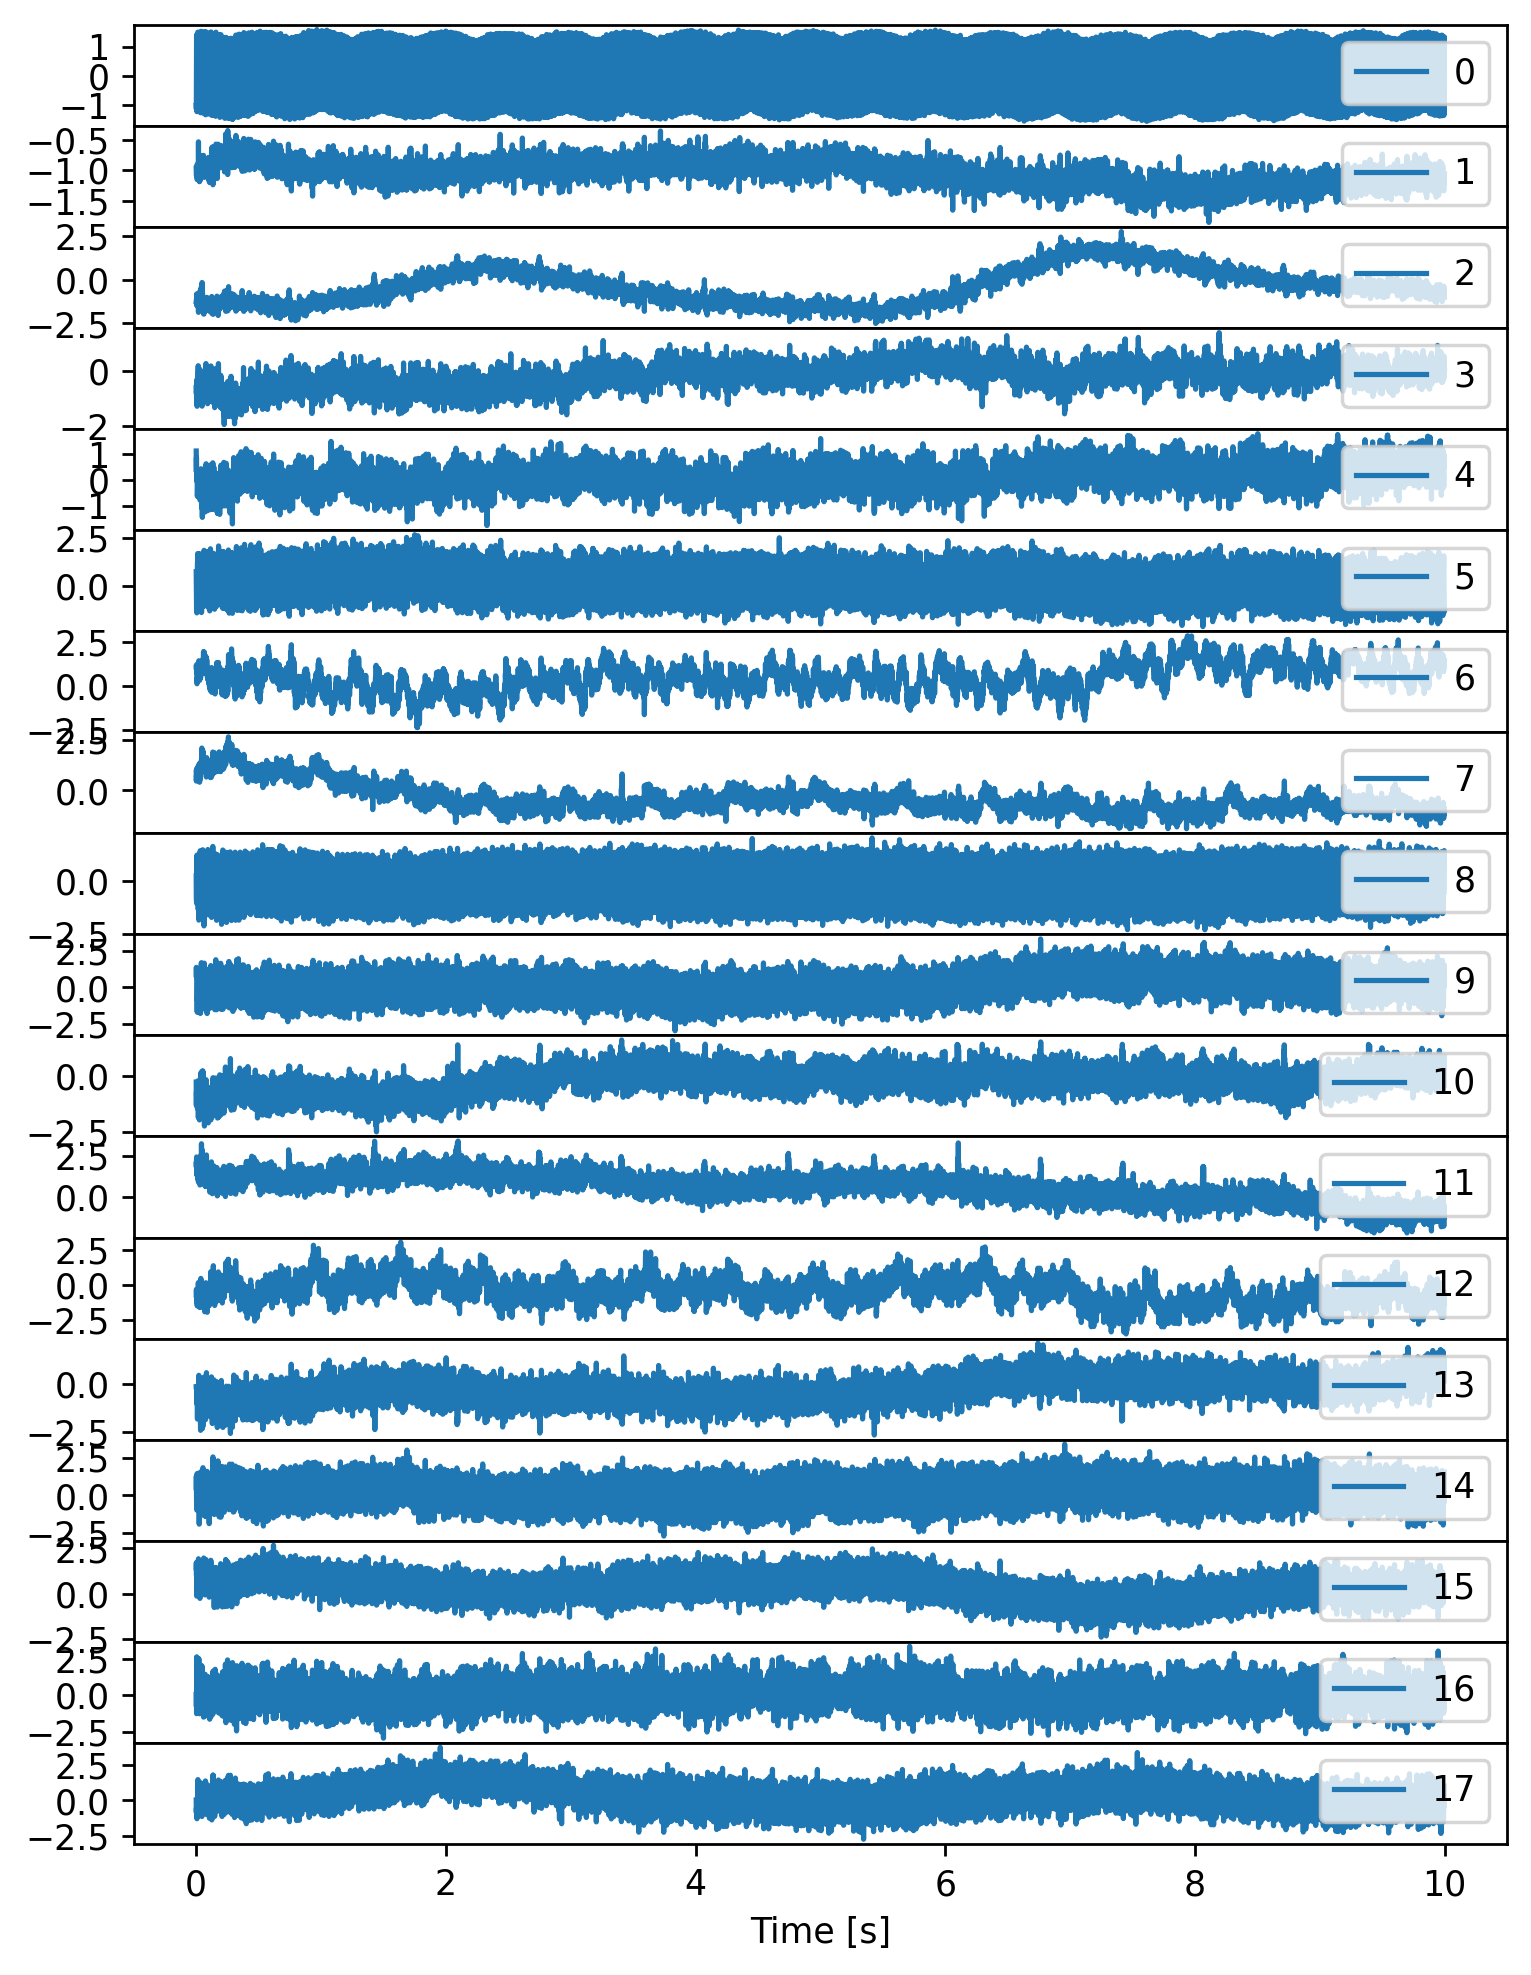

In [8]:
fig, ax = plt.subplots(no_ica_chans, 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250) #
fig.subplots_adjust(hspace=0)
    
for j in range(no_ica_chans):
    ax[j].plot(components[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

### Without butter filter, identifying components are much harder as we can see above

Here, we apply higher-order spectral filtering to see if the above components have fetal and maternal components inside.

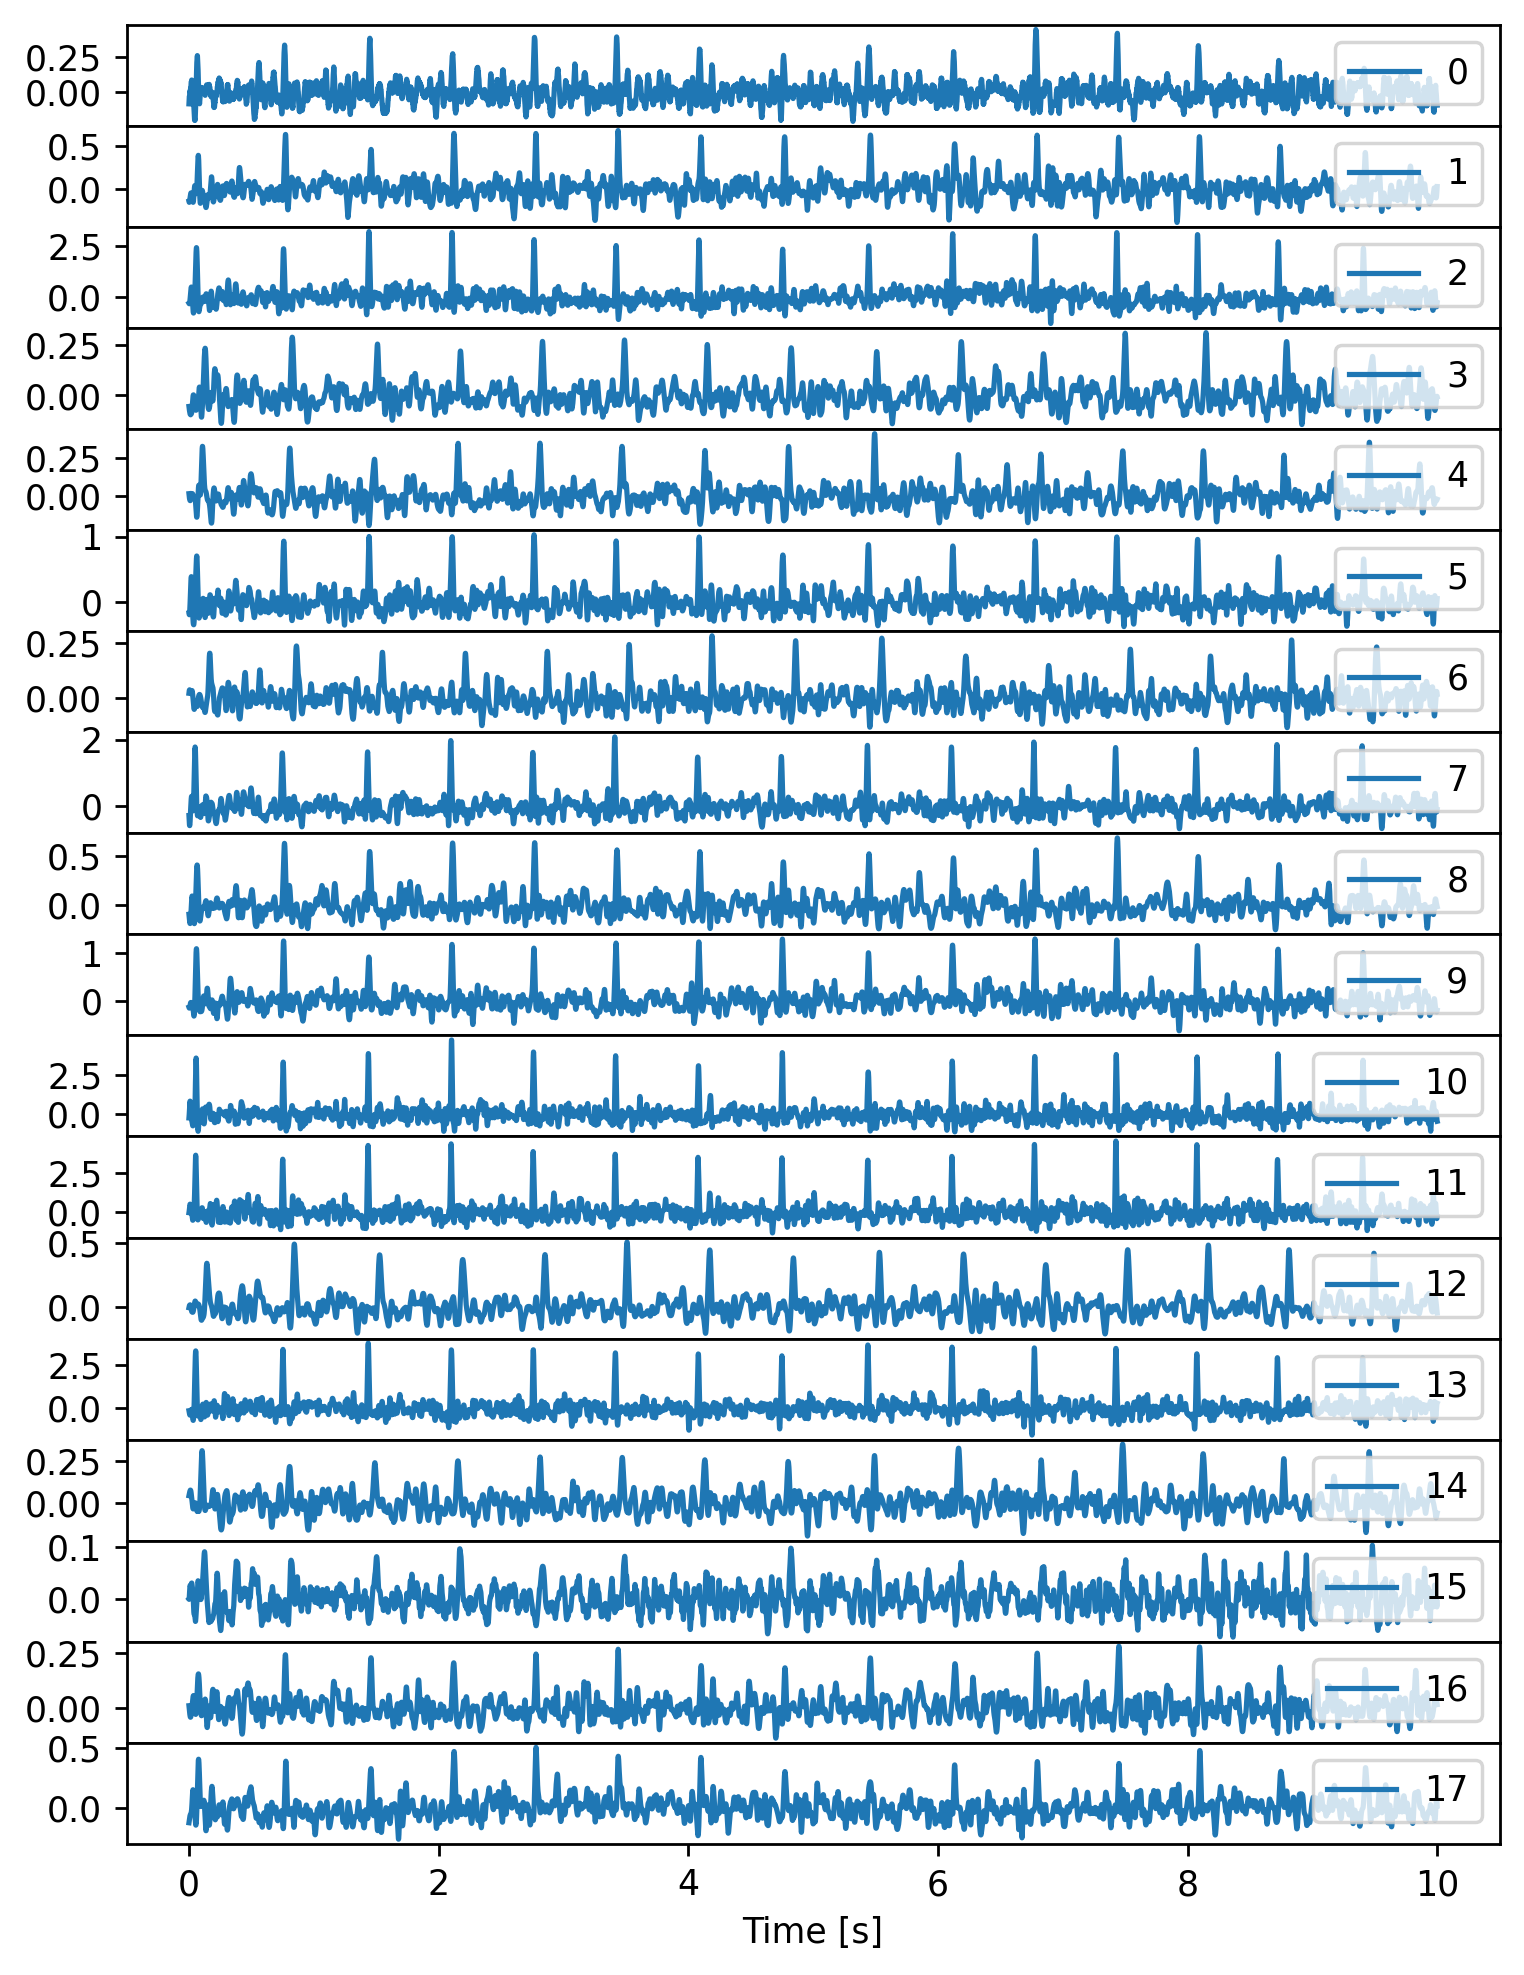

In [10]:
window_size=int(1400) # used for higher-order-spectral filtering
time_axis=np.linspace(0,int(window_size)-1,num=int(window_size))


hosded_data = np.zeros_like(components)
for component in range(components.shape[1]):
    beat, detect = apply_hosd(components[:,component], window_size) 
    hosded_data[:,component] = detect

fig, ax = plt.subplots(no_ica_chans, 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250) #
fig.subplots_adjust(hspace=0)
    
for j in range(no_ica_chans):
    ax[j].plot(hosded_data[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

### As you can see from the figure above, the fetal components is not visible, but it reconstruct the fetal component from almost every sensor except few.

The reason why we don't see any fetal component could be
- applying ICA without **basic butter filtering** obstructs the ability to recover fetal component since fetal signal is close to the noise level
- since higher-order spectral filtering (HOS filtering) only accepts one channel at a time and reconstructs peaks with highest amplitude, it might be behaving the fetal component as noise and eleminate through the filtering
    - in the original paper, they first search for a unknown matched filter, whose first derivate has higher components (higher peaks)
    - then they do thresholding to eleminate lower-amplitude peaks to reconstruct the original signal


### Let's apply some butter filtering to see what is the bare minimum to reconstruct the fetal signal

In [11]:
data_to_be_filtered = deepcopy(data)

## Let's first start with eleminating the 50Hz, power line interference to see if it causes the most trouble
b_notch, a_notch = scipy.signal.iirnotch(50, 40, fs)
for i in range(1,np.shape(data_to_be_filtered)[1]):
    data_to_be_filtered[:,i]=scipy.signal.filtfilt(b_notch, a_notch, data_to_be_filtered[:,i])


### apply ICA again to see the results

However, **ICA** was not able to produce the components, only applying notch filter breaks the seperability. Reason: not clear

In [12]:
components_notch_filter = functions.FASTICA(data_to_be_filtered[5000:, 1:], no_ica_chans)

fig, ax = plt.subplots(no_ica_chans, 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250) #
fig.subplots_adjust(hspace=0)
    
for j in range(no_ica_chans):
    ax[j].plot(components_notch_filter[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

KeyboardInterrupt: 

### Let's just try with the lowpass filter to see if it is crucial part?

I had to stop it because it run so long, it seems just having LPF also does not help, lets try with both

In [14]:
data_lpf = deepcopy(data)

## Let's now try with low pass filter of 70Hz of order 3
lowpass=scipy.signal.butter(3,70,btype='low',output='sos',fs=fs)
for i in range(1,np.shape(data_lpf)[1]):
    data_lpf[:,i]=scipy.signal.sosfilt(lowpass, data_lpf[:,i])

components_lpf = functions.FASTICA(data_lpf[5000:, 1:], no_ica_chans)

fig, ax = plt.subplots(no_ica_chans, 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250) #
fig.subplots_adjust(hspace=0)
    
for j in range(no_ica_chans):
    ax[j].plot(components_lpf[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

KeyboardInterrupt: 

### It seems having both LPF and notch also doesn't work, I've waited 84 mins

In [5]:
data_lpf_notch = deepcopy(data)

## Let's now try with low pass filter of 70Hz of order 3
lowpass=scipy.signal.butter(3,70,btype='low',output='sos',fs=fs)
b_notch, a_notch = scipy.signal.iirnotch(50, 40, fs)

for i in range(1,np.shape(data_lpf_notch)[1]):
    data_lpf_notch[:,i]=scipy.signal.sosfilt(lowpass, data_lpf_notch[:,i])
    data_lpf_notch[:,i]=scipy.signal.filtfilt(b_notch, a_notch, data_lpf_notch[:,i])

components_lpf_notch = functions.FASTICA(data_lpf_notch[5000:, 1:], no_ica_chans)

fig, ax = plt.subplots(no_ica_chans, 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250) #
fig.subplots_adjust(hspace=0)
    
for j in range(no_ica_chans):
    ax[j].plot(components_lpf_notch[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()


KeyboardInterrupt: 

### Let's also add bandstop part for 4-6 Hz (I guess this part also stem from some kind of interference), I've waited 90mins for FASTICA to seperate but didn't seperate it, so I stopped it.

In [6]:
data_bs = deepcopy(data)

## Let's now try with low pass filter of 70Hz of order 3
lowpass=scipy.signal.butter(3,70,btype='low',output='sos',fs=fs)
bandstop = scipy.signal.butter(2, [4,6], btype='bandstop', output='sos', fs=fs)
b_notch, a_notch = scipy.signal.iirnotch(50, 40, fs)

for i in range(1,np.shape(data_bs)[1]):
    data_bs[:,i]=scipy.signal.sosfilt(lowpass, data_bs[:,i])
    data_bs[:,i]=scipy.signal.sosfilt(bandstop, data_bs[:,i])
    data_bs[:,i]=scipy.signal.filtfilt(b_notch, a_notch, data_bs[:,i])

components_bs = functions.FASTICA(data_bs[5000:, 1:], no_ica_chans)

fig, ax = plt.subplots(no_ica_chans, 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250) #
fig.subplots_adjust(hspace=0)
    
for j in range(no_ica_chans):
    ax[j].plot(components_bs[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()
